# Assignment 2

**Submission deadline: last lab session before or on Wednesday 25.10.17**

**Points: 13 + 1 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions. Whenever possible, add your solutions to the notebook.

Please email us about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1 [2p] Bayes' Theorem

Bayes' theorem allows to reason about conditional probabilities of causes and their effects:

\begin{equation}
p(A,B)=p(A|B)p(B)=p(B|A)p(A)
\end{equation}

\begin{equation}
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
\end{equation}

Bayes' theorem allows us to reason about probabilities of causes, when
we observe their results.  Instead of directly answering the hard
question $p(\text{cause}|\text{result})$ we can instead separately
work out the marginal probabilities of causes $p(\text{cause})$ and
carefully study their effects $p(\text{effect}|\text{cause})$.

Solve the following using Bayes' theorem.

1. **[1p]** There are two boxes on the table: box \#1 holds two
  black balls and eight red ones, box \#2 holds 5 black ones and
  5 red ones. We pick a box at random (with equal probabilities),
  and then a ball from that box.
  1. What is the probability, that the
  ball came from box \#1 if we happened to pick a red ball?
  
1. **[1p]** The government has started a preventive program of
  mandatory tests for the Ebola virus. Mass testing method is
  imprecise, yielding 1% of false positives (healthy, but the test
  indicates the virus) and 1% of false negatives (
  having the virus but healthy according to test results).
  As Ebola is rather infrequent, lets assume that it occurs in
  one in a million people in Europe.
  1. What is the probability,
  that a random European, who has been tested positive for Ebola
  virus, is indeed a carrier?
  2. Suppose we have an additional information, that the person has just
  arrived from a country where one in a thousand people is a carrier.
  How much will be the increase in probability?
  3. How accurate should be the test, for a 80% probability of true
  positive in a European?

In [2]:
p_red_and_1 = 0.5 * 0.8 # probability of choosing box 1 and taking red ball
p_red = 0.5 * 0.8 + 0.5 * 0.5 # probability of taking red ball (from box 1 or box 2)
p_1_if_red = p_red_and_1 / p_red # probability of choosing box 1, when we know that we took red ball
print('Probability that we took ball from box 1 if the ball was red equals: {}'.format(p_1_if_red))

# We want to compute p_carrier_positive - probability of being ebola carrier if test gave positive result
p_positive_if_carrier = 0.99 # = 1 - p_negative_if_carrier = 1 - 0.01
p_carrier_in_europe = 10e-6
p_positive_if_not_carrier = 0.01
p_positive = p_carrier_in_europe * p_positive_if_carrier + (1 - p_carrier_in_europe) * p_positive_if_not_carrier
p_carrier_if_positive = p_positive_if_carrier * p_carrier_in_europe / p_positive # Bayes Theorem, (1)
print('Probability that random European who has been tested positive is indeed a carrier equals: {}'.format(p_carrier_if_positive))

p_carrier_another_country = 10e-3
p_carrier_if_positive_another_country = p_positive_if_carrier * p_carrier_another_country / p_positive
print('Probability that random European who returned from ' +
      'another country and has been tested positive is indeed ' +
      'a carrier equals: {}'.format(p_carrier_if_positive_another_country))

p_carrier_if_positive_expected = 0.8
accuracy = (p_carrier_if_positive_expected-1)*p_carrier_in_europe / (p_carrier_if_positive_expected*(2*p_carrier_in_europe-1)-p_carrier_in_europe)
print('Accuracy of the test should equal: {}'.format(accuracy))

Probability that we took ball from box 1 if the ball was red equals: 0.615384615385
Probability that random European who has been tested positive is indeed a carrier equals: 0.000989030749865
Probability that random European who returned from another country and has been tested positive is indeed a carrier equals: 0.989030749865
Accuracy of the test should equal: 2.50001875014e-06


# Problem 2 [2p + 1b] Naive Bayes Classifier

The Bayes' theorem allows us to construct a classifier in which we
model how the data is generated. Here we will describe a
simple and popular example of such a classifier called the naive
Bayes classifier.  Despite its simplicity It is quite effective for
classification of text documents (e.g. as spam and non-spam).

Let a document be a sequence of words $D=W_1,W_2,\ldots,W_n$ 
We will model generation of text documents as a two-stage process.
First, document category $C_j$ is drawn at random with probability
$p(C_j)$, also called the *a priori* probability.
To define the class-conditional probability
$p(D|C_j)$, we will make a simplifying (naive)
assumption, that every word in the document is drawn independently at
random with probability $p(W_i|C)$:

\begin{equation*}
  p(D|C_j) = p(W_1,W_2,\ldots,W_n | C_j) \approx p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j).
\end{equation*}

To infer the class of a document we apply the Bayes theorem:
\begin{equation*}   p(C_j|D) = \frac{p(D|C_j)p(C_j)}{p(D)} = \frac{p(C_j)p(W_1|C_j)p(W_2|C_j)\ldots p(W_n|C_j)}{p(D)}.
\end{equation*}
Please note that since we assumed only a finite number of classes,
we can compute the term $p(D)$ by making sure that the *a
posteriori probabilities* $p(C_j|D)$ sum to $1$ over all classes.

In this exercise we will try to mimic the language-guessing feature
of [Google Translate](https://translate.google.com/), although
on a much smaller scale.  We are given an input which is a
lower-case sequence of characters (such as *"some people like
pineapple on their pizza"*), and we determine whether the
sequence's language is English, Polish or Spanish.
We will treat each character as a separate observation.
The numbers are taken from [Wikipedia article on letter frequency](https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_letters_in_other_languages). We display the first few rows:

In [3]:
import pandas as pd
from StringIO import StringIO

wiki_table = u"""English|French|German|Spanish|Portuguese|Esperanto|Italian|Turkish|Swedish|Polish|Dutch|Danish|Icelandic|Finnish|Czech\na|8.167|7.636|6.516|11.525|14.634|12.117|11.745|12.920|9.383|10.503|7.486|6.025|10.110|12.217|8.421\nb|1.492|0.901|1.886|2.215|1.043|0.980|0.927|2.844|1.535|1.740|1.584|2.000|1.043|0.281|0.822\nc|2.782|3.260|2.732|4.019|3.882|0.776|4.501|1.463|1.486|3.895|1.242|0.565|0|0.281|0.740\nd|4.253|3.669|5.076|5.010|4.992|3.044|3.736|5.206|4.702|3.725|5.933|5.858|1.575|1.043|3.475\ne|12.702|14.715|16.396|12.181|12.570|8.995|11.792|9.912|10.149|7.352|18.91|15.453|6.418|7.968|7.562\nf|2.228|1.066|1.656|0.692|1.023|1.037|1.153|0.461|2.027|0.143|0.805|2.406|3.013|0.194|0.084\ng|2.015|0.866|3.009|1.768|1.303|1.171|1.644|1.253|2.862|1.731|3.403|4.077|4.241|0.392|0.092\nh|6.094|0.737|4.577|0.703|0.781|0.384|0.636|1.212|2.090|1.015|2.380|1.621|1.871|1.851|1.356\ni|6.966|7.529|6.550|6.247|6.186|10.012|10.143|9.600|5.817|8.328|6.499|6.000|7.578|10.817|6.073\nj|0.153|0.613|0.268|0.493|0.397|3.501|0.011|0.034|0.614|1.836|1.46|0.730|1.144|2.042|1.433\nk|0.772|0.049|1.417|0.011|0.015|4.163|0.009|5.683|3.140|2.753|2.248|3.395|3.314|4.973|2.894\nl|4.025|5.456|3.437|4.967|2.779|6.104|6.510|5.922|5.275|2.564|3.568|5.229|4.532|5.761|3.802\nm|2.406|2.968|2.534|3.157|4.738|2.994|2.512|3.752|3.471|2.515|2.213|3.237|4.041|3.202|2.446\nn|6.749|7.095|9.776|6.712|4.446|7.955|6.883|7.987|8.542|6.237|10.032|7.240|7.711|8.826|6.468\no|7.507|5.796|2.594|8.683|9.735|8.779|9.832|2.976|4.482|6.667|6.063|4.636|2.166|5.614|6.695\np|1.929|2.521|0.670|2.510|2.523|2.755|3.056|0.886|1.839|2.445|1.57|1.756|0.789|1.842|1.906\nq|0.095|1.362|0.018|0.877|1.204|0|0.505|0|0.020|0|0.009|0.007|0|0.013|0.001\nr|5.987|6.693|7.003|6.871|6.530|5.914|6.367|7.722|8.431|5.243|6.411|8.956|8.581|2.872|4.799\ns|6.327|7.948|7.270|7.977|6.805|6.092|4.981|3.014|6.590|5.224|3.73|5.805|5.630|7.862|5.212\nt|9.056|7.244|6.154|4.632|4.336|5.276|5.623|3.314|7.691|2.475|6.79|6.862|4.953|8.750|5.727\nu|2.758|6.311|4.166|2.927|3.639|3.183|3.011|3.235|1.919|2.062|1.99|1.979|4.562|5.008|2.160\nv|0.978|1.838|0.846|1.138|1.575|1.904|2.097|0.959|2.415|0.012|2.85|2.332|2.437|2.250|5.344\nw|2.360|0.074|1.921|0.017|0.037|0|0.033|0|0.142|5.813|1.52|0.069|0|0.094|0.016\nx|0.150|0.427|0.034|0.215|0.253|0|0.003|0|0.159|0.004|0.036|0.028|0.046|0.031|0.027\ny|1.974|0.128|0.039|1.008|0.006|0|0.020|3.336|0.708|3.206|0.035|0.698|0.900|1.745|1.043\nz|0.074|0.326|1.134|0.467|0.470|0.494|1.181|1.500|0.070|4.852|1.39|0.034|0|0.051|1.503\nà|0|0.486|0|0|0.072|0|0.635|0|0|0|0|0|0|0|0\nâ|0|0.051|0|0|0.562|0|0|0|0|0|0|0|0|0|0\ná|0|0|0|0.502|0.118|0|0|0|0|0|0|0|1.799|0|0.867\nå|0|0|0|0|0|0|0|0|1.338|0|0|1.190|0|0.003|0\nä|0|0|0.578|0|0|0|0|0|1.797|0|0|0|0|3.577|0\nã|0|0|0|0|0.733|0|0|0|0|0|0|0|0|0|0\ną|0|0|0|0|0|0|0|0|0|0.699|0|0|0|0|0\næ|0|0|0|0|0|0|0|0|0|0|0|0.872|0.867|0|0\nœ|0|0.018|0|0|0|0|0|0|0|0|0|0|0|0|0\nç|0|0.085|0|0|0.530|0|0|1.156|0|0|0|0|0|0|0\nĉ|0|0|0|0|0|0.657|0|0|0|0|0|0|0|0|0\nć|0|0|0|0|0|0|0|0|0|0.743|0|0|0|0|0\nč|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.462\nď|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.015\nð|0|0|0|0|0|0|0|0|0|0|0|0|4.393|0|0\nè|0|0.271|0|0|0|0|0.263|0|0|0|0|0|0|0|0\né|0|1.504|0|0.433|0.337|0|0|0|0|0|0|0|0.647|0|0.633\nê|0|0.218|0|0|0.450|0|0|0|0|0|0|0|0|0|0\në|0|0.008|0|0|0|0|0|0|0|0|0|0|0|0|0\nę|0|0|0|0|0|0|0|0|0|1.035|0|0|0|0|0\ně|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1.222\nĝ|0|0|0|0|0|0.691|0|0|0|0|0|0|0|0|0\nğ|0|0|0|0|0|0|0|1.125|0|0|0|0|0|0|0\nĥ|0|0|0|0|0|0.022|0|0|0|0|0|0|0|0|0\nî|0|0.045|0|0|0|0|0|0|0|0|0|0|0|0|0\nì|0|0|0|0|0|0|0.030|0|0|0|0|0|0|0|0\ní|0|0|0|0.725|0.132|0|0|0|0|0|0|0|1.570|0|1.643\nï|0|0.005|0|0|0|0|0|0|0|0|0|0|0|0|0\nı|0|0|0|0|0|0|0|5.114|0|0|0|0|0|0|0\nĵ|0|0|0|0|0|0.055|0|0|0|0|0|0|0|0|0\nł|0|0|0|0|0|0|0|0|0|2.109|0|0|0|0|0\nñ|0|0|0|0.311|0|0|0|0|0|0|0|0|0|0|0\nń|0|0|0|0|0|0|0|0|0|0.362|0|0|0|0|0\nň|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.007\nò|0|0|0|0|0|0|0.002|0|0|0|0|0|0|0|0\nö|0|0|0.443|0|0|0|0|0.777|1.305|0|0|0|0.777|0.444|0\nô|0|0.023|0|0|0.635|0|0|0|0|0|0|0|0|0|0\nó|0|0|0|0.827|0.296|0|0|0|0|1.141|0|0|0.994|0|0.024\nõ|0|0|0|0|0.040|0|0|0|0|0|0|0|0|0|0\nø|0|0|0|0|0|0|0|0|0|0|0|0.939|0|0|0\nř|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.380\nŝ|0|0|0|0|0|0.385|0|0|0|0|0|0|0|0|0\nş|0|0|0|0|0|0|0|1.780|0|0|0|0|0|0|0\nś|0|0|0|0|0|0|0|0|0|0.814|0|0|0|0|0\nš|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.688\nß|0|0|0.307|0|0|0|0|0|0|0|0|0|0|0|0\nť|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.006\nþ|0|0|0|0|0|0|0|0|0|0|0|0|1.455|0|0\nù|0|0.058|0|0|0|0|0.166|0|0|0|0|0|0|0|0\nú|0|0|0|0.168|0.207|0|0|0|0|0|0|0|0.613|0|0.045\nû|0|0.060|0|0|0|0|0|0|0|0|0|0|0|0|0\nŭ|0|0|0|0|0|0.520|0|0|0|0|0|0|0|0|0\nü|0|0|0.995|0.012|0.026|0|0|1.854|0|0|0|0|0|0|0\nů|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.204\ný|0|0|0|0|0|0|0|0|0|0|0|0|0.228|0|0.995\nź|0|0|0|0|0|0|0|0|0|0.078|0|0|0|0|0\nż|0|0|0|0|0|0|0|0|0|0.706|0|0|0|0|0\nž|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0.721"""
df = pd.read_table(StringIO(wiki_table), sep='|', index_col=0)
df.head()

,English,French,German,Spanish,Portuguese,Esperanto,Italian,Turkish,Swedish,Polish,Dutch,Danish,Icelandic,Finnish,Czech
a,8.167,7.636,6.516,11.525,14.634,12.117,11.745,12.920,9.383,10.503,7.486,6.025,10.110,12.217,8.421
b,1.492,0.901,1.886,2.215,1.043,0.980,0.927,2.844,1.535,1.740,1.584,2.000,1.043,0.281,0.822
c,2.782,3.260,2.732,4.019,3.882,0.776,4.501,1.463,1.486,3.895,1.242,0.565,0.000,0.281,0.740
d,4.253,3.669,5.076,5.010,4.992,3.044,3.736,5.206,4.702,3.725,5.933,5.858,1.575,1.043,3.475
e,12.702,14.715,16.396,12.181,12.570,8.995,11.792,9.912,10.149,7.352,18.910,15.453,6.418,7.968,7.562


Implement the language classifier and answer the following:

1. **[0.5p]** Naive Bayes can be implemented
    either by multiplying probabilities or by adding
    log-probabilities. Which one is better and why?
2. **[1.5p]** What is the language of the following phrases, according to the classifier (below in a code cell)? Assume equal prior language probabilities $P(C)$.
3. **[0-1 bonus]** What happens when a Naive Bayes classifier
      is applied to a document with out-of-vocabulary words? Propose
      some solutions. Relate them to the concept of Bayesian
      priors discussed during the lecture.

In [4]:
# -*- coding: utf-8 -*-
sentences = [
    u"No dejes para mañana lo que puedas hacer hoy.",
    u"Przed wyruszeniem w drogę należy zebrać drużynę.",
    u"Żeby zrozumieć rekurencję, należy najpierw zrozumieć rekurencję.",
    u"Si vale la pena hacerlo vale la pena hacerlo bien.",
    u"Experience is what you get when you didn't get what you wanted.",
    u"Należy prowokować intelekt, nie intelektualistów."]

In [5]:
# We can easily access the data.
langs = list(df)
letters = list(df.index)
print('Languages: {}'.format(','.join(langs)))
print('Letters: {}'.format(', '.join(letters)))
print(u'P(ę|Polish) = {}'.format(df.loc[u'ę'.encode('utf-8'), 'Polish']))
print(u'P(ñ|Spanish) = {}'.format(df.loc[sentences[0][16].encode('utf-8'), 'Spanish']))

# Normalize values to a probability distribution
df_norm = df.divide(df.values.sum(0) * len(langs))
#print df_norm.values.sum(0)

import numpy as np
def naive_bayes(sent, langs, df_norm):
    """Returns the most probable language of a sentence"""
    sent_processed = [ch.encode('utf-8') for ch in sent.lower() if ch not in [u' ', u'.', u',', u"'"]]
    log_probabilities = np.log(df_norm.loc[sent_processed]).sum(axis=0, skipna=False)
    # we assume equal prior probabilities, so these probabilities would only scale our log_probabilities
    # and therefore we don't have to do anything more here 
    return np.argmax(log_probabilities)
    

for sent in sentences:
   print(u'{} : {}'.format(naive_bayes(sent, langs, df_norm), sent))
print('\n\n')

Languages: English,French,German,Spanish,Portuguese,Esperanto,Italian,Turkish,Swedish,Polish,Dutch,Danish,Icelandic,Finnish,Czech
Letters: a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, à, â, á, å, ä, ã, ą, æ, œ, ç, ĉ, ć, č, ď, ð, è, é, ê, ë, ę, ě, ĝ, ğ, ĥ, î, ì, í, ï, ı, ĵ, ł, ñ, ń, ň, ò, ö, ô, ó, õ, ø, ř, ŝ, ş, ś, š, ß, ť, þ, ù, ú, û, ŭ, ü, ů, ý, ź, ż, ž
P(ę|Polish) = 1.035
P(ñ|Spanish) = 0.311
Spanish : No dejes para mañana lo que puedas hacer hoy.
Polish : Przed wyruszeniem w drogę należy zebrać drużynę.
Polish : Żeby zrozumieć rekurencję, należy najpierw zrozumieć rekurencję.
Italian : Si vale la pena hacerlo vale la pena hacerlo bien.
English : Experience is what you get when you didn't get what you wanted.
Polish : Należy prowokować intelekt, nie intelektualistów.





C:\Users\pmaslankowski\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


# Problem 3 [2p]
Given observations $x_1,\ldots,x_n$
  coming from a certain distribution,
  prove that MLE of a particular parameter of that distribution is equal to the sample mean $\frac{1}{n}\sum_{i=1}^n x_i$:
1. Bernoulli distribution with success probability $p$ and MLE $\hat{p}$,
2. Gaussian distribution $\mathcal{N}(\mu,\sigma)$ and MLE $\hat{\mu}$,
3. Poisson distribution $\mathit{Pois}(\lambda)$ and MLE $\hat{\lambda}$.

*NOTE: You can submit your solution on paper. To freeze the solution and spend late days, at minimum send a photo of your solution via e-mail.*

# Problem 4 [2p]

1. Find simple expressions for the following functions' derivatives with respect to vector $\mathbf{x}$.
    1. $\tanh(\mathbf{x})$
    2. $\sigma(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}}}$
2. Find the following functions' gradients with respect to vector $[x, y, z]^T$:
    1. $f_1([x, y, z]^T) = x + y$
    2. $f_2([x, y, z]^T) = xy$
    3. $f_3([x, y, z]^T) = x^2y^2$
    4. $f_4([x, y, z]^T) = (x + y)^2$
    5. $f_5([x, y, z]^T) = x^4 + x^2 y z + x y^2 z + z^4$
    6. $f_6([x, y, z]^T) = e^{x + 2y}$
    7. $f_7([x, y, z]^T) = \frac{1}{x y^2}$
    8. $f_8([x, y, z]^T) = ax + by + c$
    9. $f_9([x, y, z]^T) = \tanh(ax + by + c)$

# Problem 5 [2p]

Find the following functions' gradients or Jacobians with respect to vector $\mathbf{x}$, where $\mathbf{x}, \mathbf{b} \in \mathbb{R}^{n}$, $\mathbf{W} \in \mathbb{R}^{n \times n}$:

1. **[0.5p]** $\mathbf{W} \mathbf{x} + \mathbf{b}$
2. **[0.5p]** $\mathbf{x}^T \mathbf{W} \mathbf{x}$,
3. **[0.5p]** $\sigma(\mathbf{W} \mathbf{x} + \mathbf{b})$,
    with $\sigma$ applied element-wise. Hint: use the Hadamard product
    (denoted $\circ$) for element-wise matrix multiplication.
4. **[0.5p]** $-\log(S(\mathbf{x})_j)$, where $S$ is the
    softmax function
    (https://en.wikipedia.org/wiki/Softmax_function) and we are
    interested in the derivative over the $j$-th output of the
    Softmax.

# Problem 6 [2p] Linear Regression

1. Implement a function generating a dataset of $n$ points
  according to the following algorithm:
  1. Draw $n$ points $x \propto U(0;10)$ (uniformly distributed on $[0,10]$).
  2. Draw $n$ points $y \propto \mathcal{N}(1+20x-1.3x^2, 7)$
    (from a Gaussian distribution with $\mu=1+20x-1.3x^2$ and $\sigma=7$).

  Prepare a dataset of 30 elements and make a scatterplot of
  the expected value $y$ in function $x$.

2. Use linear regression to fit polynomials to the
  generated dataset. Fit polynomials of degrees zero (a constant line),
  one, two and three. An easy way to do it is to transform each data
  point $x$ into a vector of its powers $[1, x, x^2, \ldots, x^m]$.

  Plot the dataset and all regression curves on one figure.

  **Note:** The name _linear regression_ signifies that the
  hypothesis is linear with respect to parameters $\Theta$.
  However, the relationship between $x$ and $y$ is not constrained
  to a linear one. In this exercise it is a polynomial one.

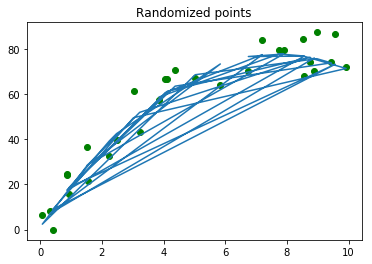

In [9]:
def make_dataset(N):
    X = np.random.uniform(0., 10., N)
    Y = np.random.normal(1 + 20 * X - 1.3 * X ** 2, 7.).reshape((-1,1))
    return X,Y

data = make_dataset(30)
scatter(data[0], data[1], color='g')
plot(data[0], 1 + 20 * data[0] - 1.3 * data[0] ** 2 )
title('Randomized points')

[ 30.80277335   5.629615  ] (2L,)
[  5.46420519  20.00446332  -1.35843451] (3L,)
[  5.74183181e+00   1.96642005e+01  -1.27547928e+00  -5.35967024e-03] (4L,)


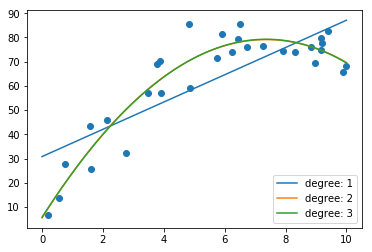

In [7]:
from numpy.linalg import inv

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(-1,1)
    return X**powers

def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1) # len(Theta) x N
    Y = Theta.reshape((1, -1)).dot(XP)
    return Y

plot_x_space = np.linspace(0,10,100)
scatter(data[0], data[1])
for degree in range(1,4):
    X = powers_of_X(data[0], degree) # Matrix d x N
    Y = data[1].reshape(1, -1)       # Matrix 1 x N
    Theta = Y.dot(X.T).dot(inv(X.dot(X.T))).reshape(-1) # Theta = Y X.T (X X.T)^-1
    plot(plot_x_space, compute_polynomial(plot_x_space, Theta).ravel(), 
         label="degree: %d" %(degree, ))
    print(Theta, Theta.shape)
legend(loc='lower right')

# Problem 7 [1p]

When the data set is small and highly dimensional (or when high degree polynomials are used) the linear regression solution may fit the noise in the data instead of capturing the general rule. We call this phenomenon overfitting and will discuss it in detail in a few lectures.

One way of preventing overfitting is to force the model's parameters to be small. We call this *regularization*. Consider the following cost function:

$$ J(\Theta) = \sum_{i=1}^N (y^{(i)} - \Theta^T x^{(i)})^2 + \frac{\lambda}{2} \Theta^T \Theta $$

Analyze datasets sampled using the following procedure:

1. $x \propto U(0;1)$: $x$ is sampled uniformly from the  $0-1$ range.
2. $y \propto \mathcal{N}(\mu=1+2x-5x^2 + 4x^3, \sigma=0.1)$: then 
    $y$ is sampled from the Normal distribution with mean 
    $\mu=1+2x-5x^2+4x^3$ and standard deviation $0.1$

Repeat 30 times an experiment in which you sample a new training
dataset, then fit polynomials of degree 0 to 14 and use $\lambda$
value from the set $\{0, 10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}\}$.

Plot the mean training and testing errors. What is the effect of increasing $\lambda$?

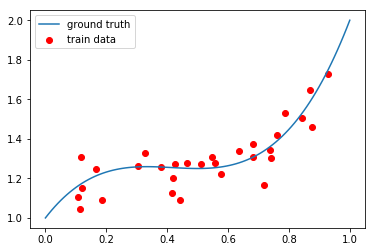

In [8]:
def poly_fun(X, Theta):
    """Compute the value of polynomial with coefficients Theta for points in X"""
    #
    # TODO: Write body of the function.
    # Return a vector of values in points from X (the same shape as X).
    # 
    return Theta.reshape((1,-1)).dot(powers_of_X(X, len(Theta) - 1)).reshape(-1)
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#
# TODO: write down the proper coefficients
#
true_poly = np.array([1., 2., -5, 4])

def make_dataset(N, theta=true_poly, sigma=0.1):
    """ Sample a dataset """
    X = np.random.rand(N)
    Y = np.random.randn(N)*sigma + poly_fun(X, true_poly)
    return X,Y


train_data = make_dataset(30)
XX = np.linspace(0,1,100)
YY = poly_fun(XX, true_poly)
scatter(train_data[0], train_data[1], label='train data', color='r')
plot(XX, poly_fun(XX, true_poly), label='ground truth')
legend(loc='upper left')

In [33]:
#import os
#os.chdir('Studia/NN/nn_assignments')
from common import plotting

ImportError: No module named common

In [35]:
#please note: lambda is a reserved keyword in python, thus we use _lambda
def poly_fit(data, degree, _lambda):
    "Fit a polynomial of a given degree and weight decay parameter C"
    powers = np.arange(degree + 1.0).reshape(-1,1)
    X = data[0].reshape(1,-1)
    Y = data[1].reshape(1,-1)
    XX = X**powers
    #
    # TODO: implement the closed-form solution for Theta
    #
    # Please note that np.inv may be numerically unstable.
    # It is better to use np.linalg.solve or even a QR decomposition.
    #
    Theta = np.linalg.solve(XX.dot(XX.T) + _lambda * np.identity(XX.shape[0]), XX.dot(Y.T))
    return Theta

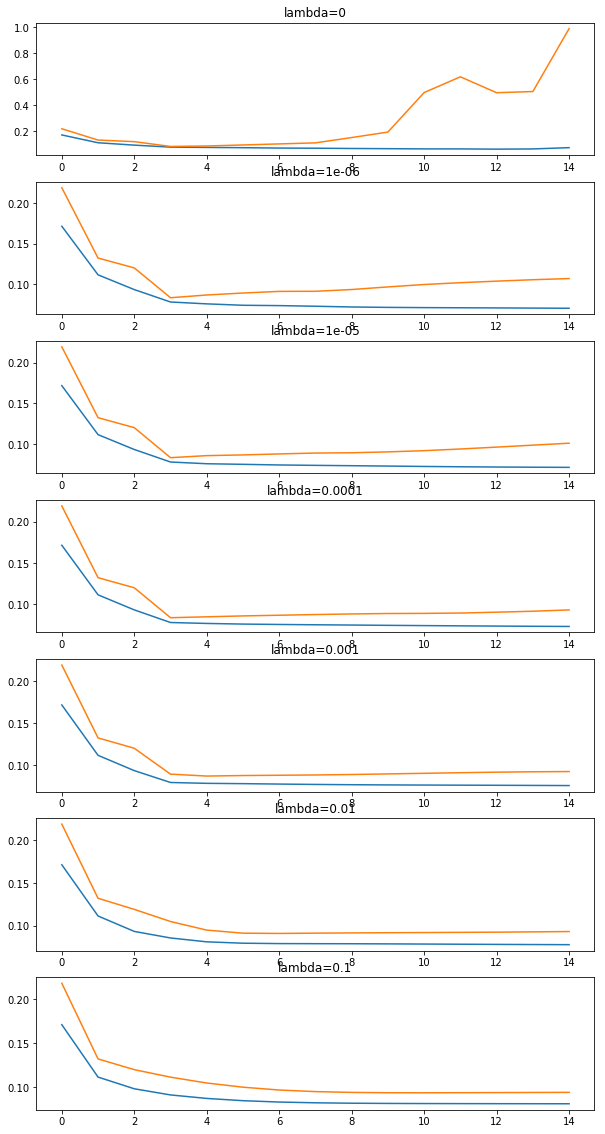

In [41]:
lambdas = [0.0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
degrees  = np.arange(15)

num_repetitions = 30
num_samples = 30

train_errors = np.zeros((len(lambdas), len(degrees)))
test_errors = np.zeros((len(lambdas), len(degrees)))

#sample a single dataset for all experiments
test_data = make_dataset(num_samples)

for repetition in xrange(num_repetitions):
    #sample a new training dataset for this repetition
    train_data = make_dataset(num_samples)
    #scatter(data[0], data[1])
    for degree_i, degree in enumerate(degrees):
        for lambda_i, _lambda in enumerate(lambdas):
            Theta = poly_fit(train_data, degree, _lambda)
            #
            # TODO: compute the mean training and test errors
            #
            X_train = train_data[0].reshape(1, -1)
            Y_train = train_data[1].reshape(1, -1)
            train_errors[lambda_i, degree_i] += np.average(np.abs(poly_fun(X_train, Theta) - Y_train))

            X_test = test_data[0].reshape(1, -1)
            Y_test = test_data[1].reshape(1, -1)
            test_errors[lambda_i, degree_i] += np.average(np.abs(poly_fun(X_test, Theta) - Y_test))
            
train_errors /=  num_repetitions
test_errors /= num_repetitions

figure(figsize=(10,20))
for lambda_i, _lambda in enumerate(lambdas):
    subplot(len(lambdas), 1, lambda_i+1)
    plot(degrees, train_errors[lambda_i,:], label='train')
    plot(degrees, test_errors[lambda_i,:],  label='test')
    #ylim(0,0.1)
    title('lambda=%g'%(_lambda,))